## Autoencoder (otomatik kodlayıcı) nedir?
Matematiksel tanımlamalardan kaçınarak olabildiğince basit bir şekilde Autoencoderların ne olduğundan bahsedelim

Basitçe girdi olarak verilen verideki bilgiyi __sıkıştırarak__ verinin kodlanmasını sağlıyor. Sonrasında da bu __sıkıştırılmış__ bilgi yığınını kullanarak tekrar girdi olarak verilen veriyi oluşturmaya çalışıyor. 

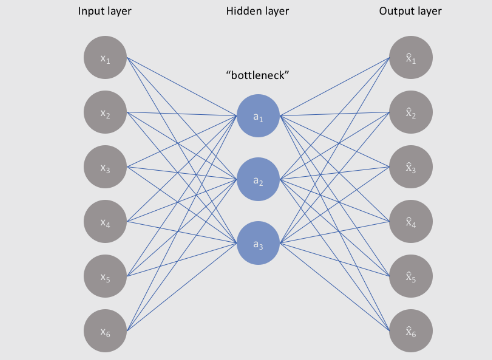




Yukarıda gördüğünüz `bottleneck` verinin sıkıştırıldığı katman oluyor. Çalışması için doğal olarak bir hata fonksiyonuna ihtiyacımız var, benim yaptığım basit örnekte üretilen ile elimizdeki görsel arasındaki farkı pikseller arasındaki farklara bağlı olarak ifade ediyoruz.

Ama mesela daha önce hiç yaşamamış insaların yüzlerini üreten bir şey yapmak istiyor olsaydık o zaman farklı bir fonksiyon kullanmamız gerekirdi.

`bottleneck` denilen bölüm verinin sıkıştırıldığı yer demiştim, dolayısıyla girdiyle alakalı olan her şey orada depolanıyor. Bunun için de __girdinin boyutu__, bottleneck'in __boyutu__ oldukça önemli. Girdi büyük fakat bottleneck küçük olursa bu durumda modelin sıkıştırmayı ve sonrasında yeniden üretmeyi öğrenmesi çok daha zor olacaktır.

Bir kaç farklı autoencoder tipi var fakat en moderni bildiğim kadarıyla VAE (Variational Autoencoder) modelleri. Benim yaptığım örnekteki __Undercomplete Autoencoder__ olarak da biliniyor. 

In [27]:
# Tensorflow ile çalışıyorum :D
import tensorflow as tf

# veriyi manipüle edebilmek için (veriyi tanımlamak, düzenlemek vs.)
import numpy as np

# modelin eğitim sonuçlarını ve encode/decode işlemini gözlemleyebilmek için 
import matplotlib.pyplot as plt

# notebooklarda plotly grafikleri gözükmüyor, bu yüzden yalnızca kendim proje üzerine çalışırken kullanıp sonrasında 
# matplotlib grafiklerine dönüştürüyorum
import plotly.graph_objects as go
import plotly.express as px

In [28]:
# MNIST datasetini yükleyelim
from tensorflow.keras.datasets import mnist

# Rakamların ne olduğuyla ilgilenmiyoruz, bu yüzden labellara gerek yok
(x_train, _), (x_test, _) = mnist.load_data()

# veriyi basit bir normalizasyondan geçiriyorum. Bu piksel değerlerinin 0 ile 1 arasında olmasını sağlıyor
# Böylece modelin yapacağı matematiksel işlemler daha kısa sürecek + weightler de 0-1 aralığında olduğundan 
# modelin eğitimi muhtemelen daha başarılı olacak
x_train = x_train / 255.0
x_test = x_test / 255.0

# Veriyi FC layerları ile işliyorum, tensorflowda bunun karşılığı Dense layerları
# Aktivasyon fonksiyonu kullanan regresyon katmanları olarak görülebilir
# Yani aktivasyon fonksiyonu f, normal regresyon çıktısı (w*x + b) = z olsun
# o zaman Dense katmanından çıkan işlenmiş veri f(z) olacak 

# FC layerlarına veriyi ancak ve ancak tek boyutlu olarak gönderebilirim. 
# Bu yüzden elimdeki veriyi (örnek miktarı, 784) olacak şekilde düzenliyorum
# Bunu yapmak için önce görselleri 28*28 = 784 boyutlu bir vektör haline getiriyorum,
# Ama tek bir görsel olmadığı için görsel sayısı*784 boyutlu bir vektör geliyor elime
# Sonrasında toplam örnek sayısına göre satırlara ayırıyorum
# Böylece (örnek sayısı, 784) şeklinde bir matrix elde ediyorum

# flatten görsel sayısı * 784 boyutlu vektörü veriyor, bunu görmek için flatten() dan sonrasını silin aşağıdaki satırlarda
# sonra reshape ile (örnek sayısı, 784) boyutlu matris olacak şekilde düzenliyorum
# x_train in normal boyutu (60000, 28, 28). O zaman x_train.shape[0] = 60000 olmalı
# bende (60000, elde ne kaldıysa) şeklinde düzenliyorum, 
# flatten dan sonra elimde örnek sayısı * 784 boyutlu veri kaldığı için
# (60000, elde ne kaldıysa) dediğimde "elde ne kaldıysa" kısmı (60000*784)/60000 = 784 olmalı
# bu yüzden sonuç olarak (60000, 784) şekline dönüşmüş oluyor
# tıpatıp aynı işlemi test verisi için de uyguluyorum.
x_train = x_train.flatten().reshape((x_train.shape[0], -1))
x_test = x_test.flatten().reshape((x_test.shape[0], -1))

# Doğru yapıp yapmadığımıza bakalım hemen
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [29]:
from tensorflow.keras.layers import Input, Dense

# Girdi boyutu (784,) olacak (tek bir örnek için)
# Bu yüzden tek bir örneğin boyutunu vermem yeterli
i = Input(shape = x_train[0].shape)
# Encode işleminin yapıldığı katmanları görebiliyorsunuz,
# Gönderilen görseli daha az veriyle ifade ediyor (64, 128)
# 128 olan encode katmanının çıktsını keyfinizce düzenleyip daha az veriye sıkıştırmayı öğretmeyi de deneyebilirsiniz
encode_dims = 32 # Bunu küçültüp daha az veriye sıkıştırabilirsiniz (yalnızca çift sayı girin ki en aşağıda görselleştirme yaparken sıkıntı çıkmasın :D)
encode = Dense(64)(i)
encode = Dense(64)(encode)
encode = Dense(encode_dims)(encode) # Son sıkıştırmayı burada yapıyor

# artık sıkıştırmayı tersine çevirip görseli tekrar oluşturma zamanı
decode = Dense(128)(encode)
# Gitgide çıktı boyutunu arttırarak en sonunda verilen görselle aynı olmasını sağlıyorum
decode = Dense(28*14)(decode) # Girdi boyutu 784 idi, bende yavaş yavaş ona yaklaşıyorum
# burada x_train[0].shape = (784,) ve x_train[0].shape[0] = 784 olduğundan girdiyle aynı boyutta bir çıktı veriyor en sonunda
o = Dense(x_train[0].shape[0])(decode) 

# şimdi bu modeli oluşturabiliriz
model = tf.keras.models.Model(i, o)


# gradient descent uygulayacak optimizer fonksiyonumuz 'adam'
# modelin yaptıklarıyla arasındaki farkı ölçecek olan şey MSE (Mean Squared Error) fonksiyonu
# tek tek her bir pikselin arasındaki değer farkının karesini alıp toplar.
# Bu toplamın ortalamasını hata skoru olarak gösterecek
# MAE de (Mean Absolute Error) aralarındaki farkları mutlak değerce toplayıp ortalamasını alarak kullanır.
model.compile(optimizer = 'adam',
              loss = 'mse', # model bu fonksiyon ile optimize ediliyor
              metrics = ['mae']) # ama ekstra olarak bunu da gösterecek

In [30]:
# artık eğitelim :D
# batch_size burada verinin kaçlı gruplar halinde işleneceğini gösteriyor
# yani eğer 64 ise elimizdeki toplam veriyi 64'e bölecek.
# Bu durumda mesela antrenman için elimizde 60000 örnek vardı
# eğer batch_size = 64 olursa veri 64 adet eşit miktarda görsel içeren gruba ayrılacak
# Bu durumda 60000/64 yaklaşık olarak 938 olduğu için her bir adımda (epoch) 938 adet görselden oluşan 64 tane grup işleyecek
# toplamda 20 adımdan sonra antrenman duracak, epochs parametresi bunu belirtiyor.
# fotoğrafı önce şifreleyip sonra eski haline geri döndürmeyi öğretmeye çalışıyoruz, bu yüzden
# modelden beklediğimiz çıktı da ona giren fotoğrafla aynı olacak. 
# O yüzden hedefimiz yani Y de modele gönderdiğimiz fotoğraflar yani X oluyor.

# validation verisi modeli eğitim esnasında test verisinde test ediyor
r = model.fit(x_train, x_train, validation_data = (x_test, x_test),
              batch_size = 64, epochs = 20)

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0217 - mae: 0.0825 - val_loss: 0.0174 - val_mae: 0.0735
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0177 - mae: 0.0736 - val_loss: 0.0172 - val_mae: 0.0721
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0176 - mae: 0.0729 - val_loss: 0.0171 - val_mae: 0.0719
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0176 - mae: 0.0726 - val_loss: 0.0173 - val_mae: 0.0722
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0175 - mae: 0.0724 - val_loss: 0.0171 - val_mae: 0.0718
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0175 - mae: 0.0723 - val_loss: 0.0172 - val_mae: 0.0718
Epoch 7/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0175 - mae: 0.0721 - val_loss: 0.0170 - val_mae: 0.0713
Epoch 8/20
938/938 [==============================] - 7s 8ms/step - loss: 0.

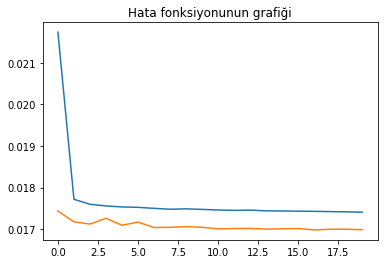

In [31]:
# Modelin antrenman skorlarını grafiğe dökelim
# model.fit fonksiyonu History denilen bir obje döndürüyor
# bunun içinde de history adında bir dict var, bunun sayesinde eğitimde hesaplanan hata skoru veya MAE skoru gibi şeylere erişebiliyorum
plt.title('Hata fonksiyonunun grafiği')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.show()

# Burada grafikten çıkarabileceğimiz en önemli çıkarım model eğitiminin oldukça başarılı olduğu ve 5. adımdan sonra gelişmenin neredeyse durduğu
# Yani 5 epoch ile eğitmekte yeterli olacaktır bu durumda. (bunu da değiştirip tekrar eğitmeyi deneyin)
# MAE değerlerini grafiğe dökmek pek anlamlı değil, o yüzden onunla uğraşmıyorum.

In [32]:
# Modelin katmanları bunlar, girdi (Input) katmanı dahil olmak üzere ilk 4 tanesi şifrelemeyi sağlıyor
# Son 3 tanesi de o şifreyi çözmeye çalışıyor
model.layers

In [33]:
# burada yazdığım fonksiyon bir sayının orta çarpanını almamı sağlıyor, 
# genel projeyle bir alakası yok sadece grafikleri görmede kolaylık olsun diye yazıyorum
def mid_multiplier(num):
  multipliers = [i for i in range(1, num+1) if num%i == 0][::-1] # sayının çarpanlarını bulup büyükten küçüğe sıralıyorum
  return multipliers[len(multipliers)//2 - 1]

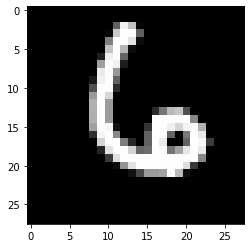

Encode edilmiş (kodlanmış) görsel:


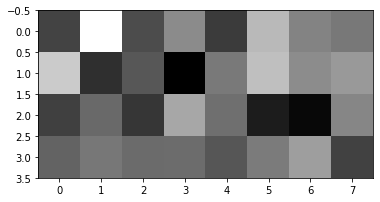

Decode edilmiş (kodu çözülmüş) görsel:


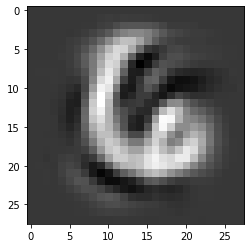

In [34]:
# Rastgele bir görsel alabilmek için rastgele indis almam gerekiyor.
random_idx = np.random.randint(0, len(x_test)-1)

# Artık indis olduğundan görseli alabilirim
# veriyi modelden geçirirken bir grup (batch) halinde geçiriyoruz bu yüzden eğer tek bir fotoğraf geçirmek istiyorsam
# onu tek bir fotoğraftan oluşan bir grup olarak göstermeliyim. Bunun için boyutlarını (1, 784) olacak şekilde düzenliyorum
test_img = x_test[random_idx].reshape((1, 784))
# Aldığımız veri normalde (784,) şeklindeydi, bunu göstermek istiyorsam 28x28 olacak şekilde tekrar düzenlemeliyim
test_img_reshaped = test_img.reshape((28,28))
# modele göndereceğim veri ile göstereceğim veri birbirinden farklı değişkenlerde depolanıyorlar, buna dikkat edelim :D

# görseli görüntüleyelim
plt.imshow(test_img_reshaped, cmap = 'gray')
plt.show()
# Şimdi ilk 4 katmanı kullanarak şifreleyelim
data = model.layers[0](test_img)
data = model.layers[1](data)
data = model.layers[2](data)
data = model.layers[3](data)
print('Encode edilmiş (kodlanmış) görsel:')
# ilk önce tensörden matrise çevirelim 
encoded_data = data.numpy()
# Son şifreleme katmanının çıktısı encode_dims değişkeninde duruyor, bunu görüntülemek için yukarıda yazdığım fonksiyonu kullanıyorum
n_col = mid_multiplier(encode_dims) # encode_dims sayısının ortanca çarpanını sütun sayısı olarak kullanacağım
# eğer verinin n_rows*n_cols boyutlarında olması gerekiyorsa ve encode_dims sayısı n_col ile bölünebiliyorsa 
# n_rows yerine encode_dims/n_col kullanabilirim. 
encoded_data_shape = (int(encode_dims/n_col), n_col)
encoded_img = data.numpy().reshape(encoded_data_shape)
plt.imshow(encoded_img, cmap = 'gray')
plt.show()
print('Decode edilmiş (kodu çözülmüş) görsel:')
# Şimdi kodlamayı tersine çevirip görseli tekrar oluşturmak için kalan 3 katmandan geçirelim
for layer in model.layers[4:]:
  data = layer(data)

# İşlem tersine döndüğünde girdiyle aynı boyutta bir şey çıkacak, bu yüzden onu da boyutları 28x28 şekilde düzenliyorum (reshape ile)
data = data.numpy().reshape((28,28))
plt.imshow(data, cmap = 'gray')
plt.show()

## Denoising Autoencoder (Gürültü arındırıcı Autoencoder)

Bunlarda başlangıçta anlattığıma benzer şekilde çalışıyorlar. Sadece girdi olarak verilen veri __gürültü__ eklenmiş veri oluyor. 


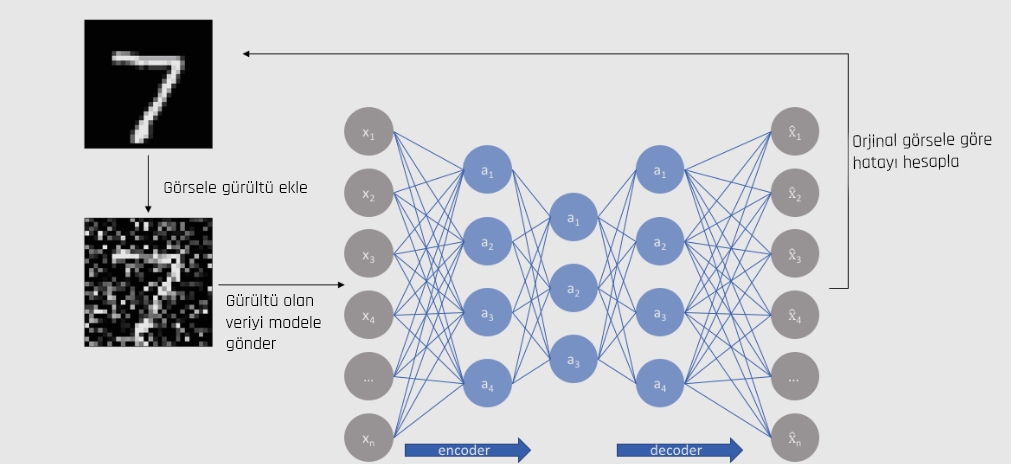


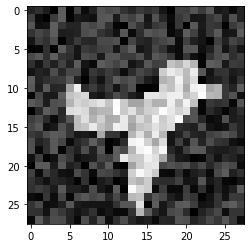

In [35]:
# Gürültü ekleyebilmek için veriyi tekrar yüklüyorum
(x_train, _), (x_test, _) = mnist.load_data()

train_noise = np.random.random((28,28))
test_noise = np.random.random((28,28))

x_train = x_train + ( (train_noise) * 150 )
x_test = x_test + ( (test_noise) * 150 )


# gerçek normalization uyguluyorum, veri grubunu ortalaması 0 ve standart dağılımı 1 olacak bir hale dönüştürüyor
x_train = ( x_train - x_train.mean() ) / x_train.std()
x_test = ( x_test - x_train.mean() ) / x_train.std()

# flatten the input data
x_train = x_train.flatten().reshape(x_train.shape[0], -1)
x_test = x_test.flatten().reshape(x_test.shape[0], -1 )

# şimdi gürültü eklenmiş örnek bir fotoğraf gösterelim
random_idx = np.random.randint(0, len(x_train) - 1)
plt.imshow(x_train[random_idx].reshape((28,28)), cmap = 'gray')

In [44]:
i = Input(shape = x_train[0].shape)

encode_dims = 64 

encode = Dense(256)(i)
encode = Dense(128)(encode)
encode = Dense(encode_dims)(encode)

decode = Dense(128)(encode)
decode = Dense(28*14)(decode)
o = Dense(x_train[0].shape[0])(decode) 

model = tf.keras.models.Model(i, o)

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mae'])

In [45]:
r = model.fit(x_train, x_train, validation_data = (x_test, x_test), epochs = 20, batch_size = 64)

Epoch 1/20
938/938 [==============================] - 9s 10ms/step - loss: 0.1296 - mae: 0.2078 - val_loss: 5341.9775 - val_mae: 59.1056
Epoch 2/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0811 - mae: 0.1634 - val_loss: 5234.3613 - val_mae: 59.1266
Epoch 3/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0797 - mae: 0.1606 - val_loss: 5269.7529 - val_mae: 59.2246
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0795 - mae: 0.1598 - val_loss: 5435.7344 - val_mae: 60.6494
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0786 - mae: 0.1578 - val_loss: 6092.8638 - val_mae: 64.8344
Epoch 6/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0783 - mae: 0.1569 - val_loss: 6036.4268 - val_mae: 64.4936
Epoch 7/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0781 - mae: 0.1564 - val_loss: 6142.7715 - val_mae: 65.0446
Epoch 8/20
938/938 [=====================

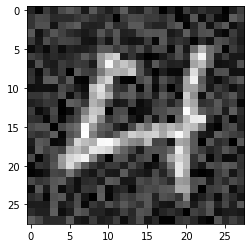

Encode edilmiş (kodlanmış) görsel:


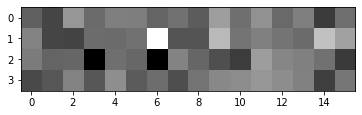

Decode edilmiş (kodu çözülmüş) görsel:


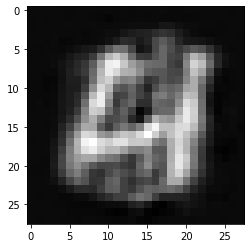

In [46]:
random_idx = np.random.randint(0, len(x_test)-1)

test_img = x_test[random_idx].reshape((1, 784))
test_img_reshaped = test_img.reshape((28,28))

plt.imshow(test_img_reshaped, cmap = 'gray')
plt.show()
data = model.layers[0](test_img)
data = model.layers[1](data)
data = model.layers[2](data)
data = model.layers[3](data)

print('Encode edilmiş (kodlanmış) görsel:')
encoded_data = data.numpy()
n_col = mid_multiplier(encode_dims)
encoded_data_shape = (int(encode_dims/n_col), n_col)
encoded_img = data.numpy().reshape(encoded_data_shape)
plt.imshow(encoded_img, cmap = 'gray')
plt.show()
print('Decode edilmiş (kodu çözülmüş) görsel:')
for layer in model.layers[4:]:
  data = layer(data)

data = data.numpy().reshape((28,28))
plt.imshow(data, cmap = 'gray')
plt.show()